# Multi Label Classification Model

In [1]:
# !pip3 install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

## Imports

In [2]:
# import os 
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Basic imports
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch imports
import torch
import torchvision
import torch.optim as optim
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Custom functions
from processing_functions import *

## GPU Setup

In [4]:
# check if GPU available and assign it
torch.cuda.is_available()
device = torch.device('cuda', 1)
device

device(type='cuda', index=0)

## DataLoader

In [5]:
class TeethDataLoader_MultiLabel(data.Dataset): # input is folder name where folders of teeth are stored
                                        # requires overwrite __getitem__(), supporting fetching a data sample for a given key
                                        # can also overwrite __len__(), which is expected to return the size of the dataset


    def __init__(self, xray_path, anomaly_path, segmentation_path): # path below = ./training_images/
                
        xray_filenames = os.listdir(xray_path)
        anomaly_filenames = os.listdir(anomaly_path)
        segmentation_filenames = os.listdir(segmentation_path)

        output_path = 'SegmentedTeethImages/'
        
        self.images, self.labels = [], []

        for i in range(len(anomaly_filenames)):
            # Create dataframe with tooth number
            print(anomaly_path + anomaly_filenames[i])
            anomalies_df = anomaly_matching(anomaly_path + anomaly_filenames[i], 
                                            segmentation_path + segmentation_filenames[i], 
                                            io.imread(xray_path + xray_filenames[i]).shape, 
                                            normalized=True)
            anomalies_df = multi_labeling(anomalies_df)
            
            for index, row in anomalies_df.iterrows():
                yolo_coord = row[['x_center', 'y_center', 'width', 'height']].to_list()
                tooth_file = extract_image(xray_path + xray_filenames[i],
                                           yolo_coord, 
                                           int(row['tooth_number']), 
                                           output_folder=output_path, 
                                           print_names=False)
                self.images.append(tooth_file)
                self.labels.append(row['anomaly_category'])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img = cv2.imread(self.images[index])     # loads image from file
        img = cv2.resize(img, (224, 224))        # resize image to 224x224
        img = np.array(img, dtype=np.float32)    # change data type to float
        img = (img / 255.)                       # normalize colors to be 0-1
        img = img[:, :, (2, 1, 0)]               # reorder RGB
        img = torchvision.transforms.ToTensor()(img)  # convert to tensor
        label = self.labels[index]               # 1 or 0
        
        return img.float(), torch.FloatTensor([label]) # returns tensor of modified image and label

## Modeling Setup

In [6]:
from torchvision import models as models

def model(pretrained, requires_grad):
    model = models.resnet50(progress=True, pretrained=pretrained)
    # to freeze the hidden layers
    if requires_grad == False:
        for param in model.parameters():
            param.requires_grad = False
    # to train the hidden layers
    elif requires_grad == True:
        for param in model.parameters():
            param.requires_grad = True
    # make the classification layer learnable
    model.fc = nn.Linear(2048, 8)
    return model

In [7]:
import torch
from tqdm import tqdm
# training function
def train(model, dataloader, optimizer, criterion, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    for (x, y) in tqdm(train_loader):
        counter += 1
        data, target = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, target.squeeze(1))
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        
    train_loss = train_running_loss / counter
    return train_loss


# validation function
def validate(model, dataloader, criterion, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    with torch.no_grad():
        for (x, y) in tqdm(train_loader):
            counter += 1
            data, target = x.to(device), y.to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, target.squeeze(1))
            val_running_loss += loss.item()
        
        val_loss = val_running_loss / counter
        return val_loss

## Model Training

In [8]:
#intialize the model
model = model(pretrained=True, requires_grad=False).to(device)
# learning parameters
lr = 0.0001
epochs = 5
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss()

In [9]:
xray_path = 'Test_images/panoramic0/'
anomaly_path = 'Test_images/panoramic0_labels/'
segmentation_path = 'Test_images/panoramic0_teeth_segmented/'

dataset = TeethDataLoader_MultiLabel(xray_path, anomaly_path, segmentation_path)

# generate shuffled sequence of numbers based on how many images, split train/test
train_idx, valid_idx= train_test_split(np.arange(len(dataset.labels)), test_size=0.2, shuffle=True)

# Samples elements randomly from a given list of indices, without replacement
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

# loads images associated with ids/samples from above
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

Test_images/panoramic0_labels/cate2-00001.txt
Test_images/panoramic0_labels/cate2-00002.txt
Test_images/panoramic0_labels/cate2-00003.txt
Test_images/panoramic0_labels/cate2-00005.txt
Test_images/panoramic0_labels/cate2-00006.txt
Test_images/panoramic0_labels/cate2-00007.txt
Test_images/panoramic0_labels/cate2-00008.txt
Test_images/panoramic0_labels/cate2-00010.txt
Test_images/panoramic0_labels/cate2-00011.txt
Test_images/panoramic0_labels/cate2-00012.txt
Test_images/panoramic0_labels/cate2-00013.txt
Test_images/panoramic0_labels/cate2-00014.txt
Test_images/panoramic0_labels/cate2-00015.txt
Test_images/panoramic0_labels/cate2-00016.txt
Test_images/panoramic0_labels/cate2-00017.txt
Test_images/panoramic0_labels/cate2-00021.txt
Test_images/panoramic0_labels/cate2-00025.txt
Test_images/panoramic0_labels/cate2-00033.txt
Test_images/panoramic0_labels/cate2-00035.txt
Test_images/panoramic0_labels/cate2-00036.txt
Test_images/panoramic0_labels/cate2-00037.txt
Test_images/panoramic0_labels/cate

In [10]:
# start the training and validation
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_loader, optimizer, criterion, device
    )
    valid_epoch_loss = validate(
        model, valid_loader, criterion, device
    )
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:23<00:00,  2.86it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:09<00:00,  7.21it/s]


Train Loss: 0.2500
Val Loss: 0.1547
Epoch 2 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.64it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:09<00:00,  7.40it/s]


Train Loss: 0.1450
Val Loss: 0.1393
Epoch 3 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:09<00:00,  7.10it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:09<00:00,  7.27it/s]


Train Loss: 0.1358
Val Loss: 0.1318
Epoch 4 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.79it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.78it/s]


Train Loss: 0.1311
Val Loss: 0.1279
Epoch 5 of 5
Training


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.59it/s]


Validating


100%|██████████████████████████████████████████████████████████████████████████████████| 68/68 [00:10<00:00,  6.52it/s]

Train Loss: 0.1277
Val Loss: 0.1255


## Visualizing Performance

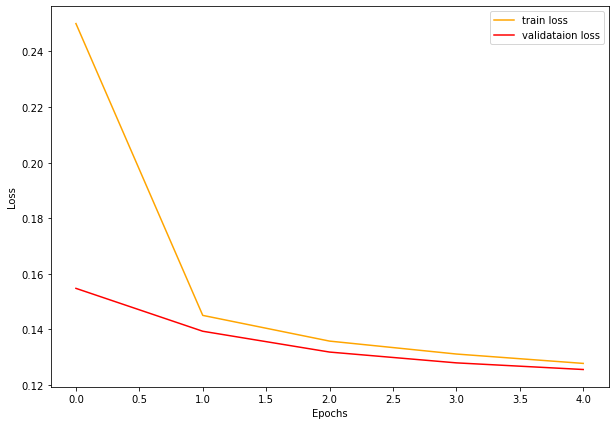

In [11]:
import matplotlib.pyplot as plt 

torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, 'model.pth')
# plot and save the train and validation line graphs
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(valid_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()